# LightGBM graphs

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
%matplotlib inline
style.use('seaborn-v0_8-ticks')


*Available targets = { 'h', 'GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18'}*

In [18]:
target = 'MB8'
unit = 'MASL' if 'GV' in target else 'L/s' if 'MB' in target else None

with open(f'plotting_data/LightGBM/LightGBM_{target}_plotting_data.pkl', 'rb') as f:
    plotting_data = pickle.load(f)

# Extract data for plotting
dates = plotting_data['dates']
actual_y = plotting_data['actual_y']
predictions = plotting_data['predictions']
# split_index_val = plotting_data['split_index_val']
# split_index_test = plotting_data['split_index_test']
split_index = plotting_data['split_index']
RMSE = plotting_data['RMSE']
MAE = plotting_data['MAE']
NSE = plotting_data['NSE']
KGE = plotting_data['KGE']

# Split according to train, validation and test size
y_train = actual_y.iloc[:split_index]
y_test = actual_y.iloc[split_index:] 
train_predictions = predictions[:split_index]
test_predictions = predictions[split_index:]
test_dates = dates.iloc[split_index:]

print("Data loaded")

Data loaded


<Figure size 640x480 with 0 Axes>

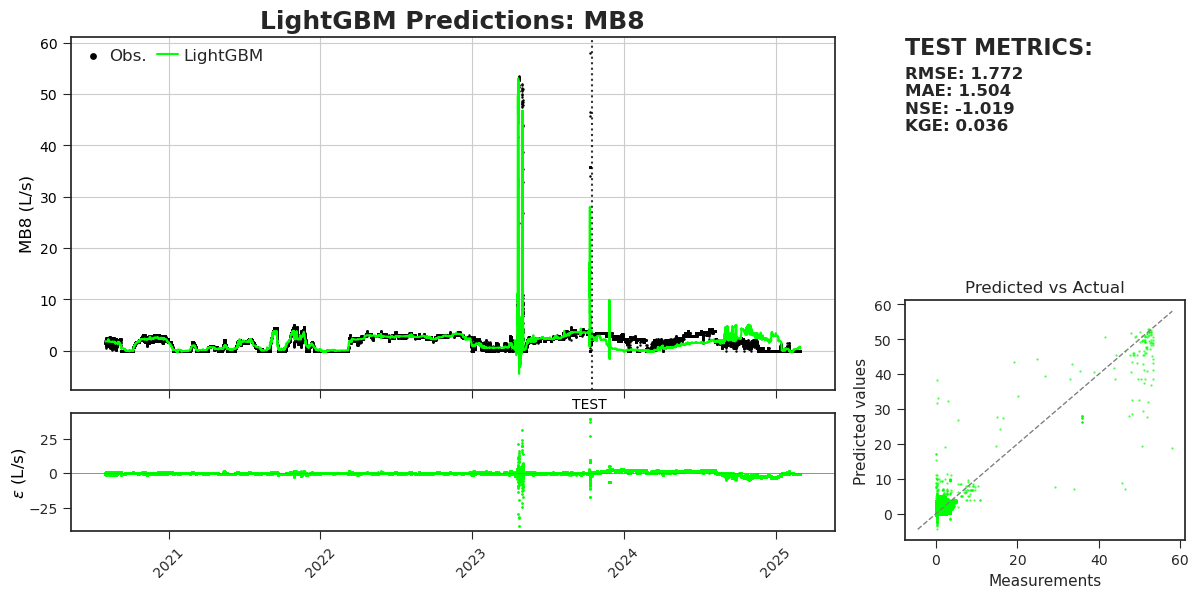

In [19]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
color_LightGBM = 'lime'

# Data and predictions
ax1.scatter(dates, actual_y, color='black', s=0.6, label='Obs.')
# ax1.plot(dates, actual_y, color='blue', linewidth=0.5, alpha=0.3)
ax1.plot(dates, predictions, color=color_LightGBM, linewidth=1.5, label='LightGBM')
ax1.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
fig.text(0.4125, 0.31, 'TEST', color='black')

ax1.set_ylabel(f'{target} ({unit})', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left', fontsize=12, ncols=2, markerscale=5, \
           columnspacing=0.6, handlelength=1.3, handletextpad=0.3, borderpad=0.2)
ax1.set_title(f'LightGBM Predictions: {target}', fontsize=18, fontweight='bold')
ax1.grid()

# Residuals
residuals = actual_y - predictions
ax2.scatter(dates, residuals, color=color_LightGBM, s=1)
ax2.axhline(y=0, color='gray', linewidth=0.6, linestyle='-')
ax2.set_ylabel(rf'$\epsilon$ ({unit})', color='black', fontsize=12, labelpad=0)
# ax2.set_ylim(-4, 4)
# ax2.set_yticks(range(int(residuals.min()), int(residuals.max())+1, 4))
# ax2.tick_params(axis='y', labelcolor='purple')

# Formatting
plt.xticks(rotation=45)  
fig.tight_layout()  

# Text
fig.subplots_adjust(right=0.6)
title_text = "TEST METRICS:"
rmse_text = f'RMSE: {RMSE:.3f}'
mae_text = f'MAE: {MAE:.3f}'
NSE_text = f"NSE: {NSE:.3f}"
KGE_text = f"KGE: {KGE:.3f}"

metrics_text = '\n'.join([rmse_text, mae_text, NSE_text, KGE_text])
fig.text(0.65, 0.93, title_text, verticalalignment='top', fontweight='bold', fontsize=16)
fig.text(0.65, 0.88, metrics_text, verticalalignment='top', fontweight='bold', fontsize=12)

# Scatter plot for predicted vs measured values
ax3 = fig.add_axes([0.65, 0.09, 0.2, 0.4]) #type: ignore (Manually placed)

# Add a grey diagonal line from bottom-left to top-right
min_val = min(actual_y.min(), predictions.min())
max_val = max(actual_y.max(), predictions.max())
ax3.plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='--', linewidth=1)

# Plot
ax3.scatter(actual_y, predictions, color=color_LightGBM, alpha=0.5, s=0.5, marker='D')
ax3.set_xlabel(f'Measurements', fontsize=11)
ax3.set_ylabel(f'Predicted values', fontsize=11)
ax3.set_title('Predicted vs Actual', fontsize=12)

plt.show()

# # Optimize quality by saving the plot with high DPI
# plt.savefig('high_quality_plot.png', dpi=300, bbox_inches='tight')

# # Alternatively, saving in vector format (SVG or PDF) to maintain quality on zoom
# plt.savefig('high_quality_plot_SVG.svg', dpi=300, bbox_inches='tight')

In [4]:
perm_importances = plotting_data['perm_importances']
perm_labels = plotting_data['perm_labels']

fig = plt.figure(figsize=(8, 6))
plt.subplot(1, 1, 1)
plt.boxplot(
    perm_importances,
    vert=False,
    labels=perm_labels,
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

KeyError: 'perm_importances'

In [ ]:
native_importances = plotting_data['native_importace']
# perm_labels = plotting_data['perm_labels']

print(native_importances)

# fig = plt.figure(figsize=(8, 6))
# plt.subplot(1, 1, 1)
# plt.boxplot(
#     native_importances,
#     vert=False,
#     # labels=perm_labels,
# )
# plt.title("Native Importance (test set)")
# fig.tight_layout()
# plt.show()

[ 91 270   7   8 272 227  62  10   2   0 107 113 152 147 493 109   0  30]
